# 1.関数の定義

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

def loocv_gpy(df: pd.DataFrame,
              X_cols: list,
              Y_col: str,
              standardize: bool = True,
              use_ard: bool = False,
              kernel=None):
    """
    GPyでのLOOCVを行い、R2スコアと予測プロットを出力。

    Parameters:
        df: 入力DataFrame
        X_cols: 説明変数カラム名リスト
        Y_col: 目的変数カラム名
        standardize: 標準化の有無
        use_ard: ARD有効化
        kernel: GPyのカーネル（指定がなければRBF）

    Returns:
        r2スコア（float）と y-y 散布図を表示
    """

    X_all = df[X_cols].values
    y_all = df[[Y_col]].values  # (n, 1) にするため [[]]

    n = len(df)
    y_true = []
    y_pred = []

    for i in range(n):
        # 学習データ（iを除外）
        X_train = np.delete(X_all, i, axis=0)
        y_train = np.delete(y_all, i, axis=0)
        X_test = X_all[i].reshape(1, -1)
        y_test = y_all[i].reshape(1, -1)

        # 標準化（LOOCVループ内で各回ごとにfit → データリーク防止）
        if standardize:
            x_scaler = StandardScaler().fit(X_train)
            y_scaler = StandardScaler().fit(y_train)

            X_train = x_scaler.transform(X_train)
            X_test = x_scaler.transform(X_test)
            y_train = y_scaler.transform(y_train)
        else:
            y_scaler = None

        # カーネルの初期化（ARDを含むRBFなど）
        input_dim = X_train.shape[1]
        if kernel is None:
            kernel_used = GPy.kern.RBF(input_dim=input_dim, ARD=use_ard)
        else:
            kernel_used = kernel.copy()  # 毎回コピー

        # モデルの作成と最適化
        model = GPy.models.GPRegression(X_train, y_train, kernel_used)
        # model.optimize(messages=False)
        # model.optimize_restarts(num_restarts=10, verbose=False)
        model.optimize(messages=False, max_iters=100)

        # 予測と逆標準化（必要に応じて）
        y_pred_i, _ = model.predict(X_test)
        if standardize:
            y_pred_i = y_scaler.inverse_transform(y_pred_i)

        y_true.append(y_test[0, 0])
        y_pred.append(y_pred_i[0, 0])

    # R2算出とプロット
    r2 = r2_score(y_true, y_pred)
    print(f"LOOCV R²: {r2:.4f}")

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--', color='gray')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title("y vs ŷ (LOOCV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return r2


# 2.dfの準備

In [2]:
input = "/Users/macmini/Documents/多目的最適化の理論構築/train/result0.xlsx"
df_all = pd.read_excel(input)

X_cols = ["F12","F13","F14","F15","F16","F20","F0","R12","R13","R14","R15","R16","R20","R0"]
Y_col_mwave1 = "mwave1"
Y_col_mstrength1 = "mstrength1"
Y_col_dwave1 = "dwave1"
Y_col_dstrength1 = "dstrength1"

# df_all.head()

# 3.LOOCVの実行

LOOCV R²: 0.9942


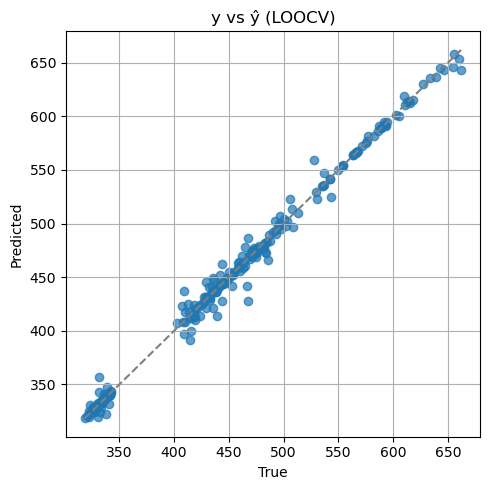

mwave1 LOOCV R²: 0.9941593693943717
LOOCV R²: 0.9856


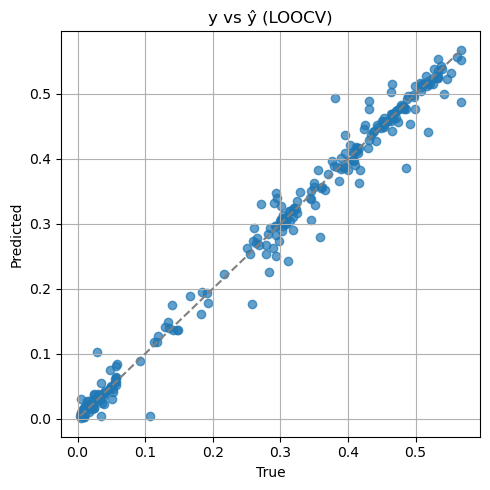

mstrength1 LOOCV R²: 0.9855590622007101
LOOCV R²: 0.6494


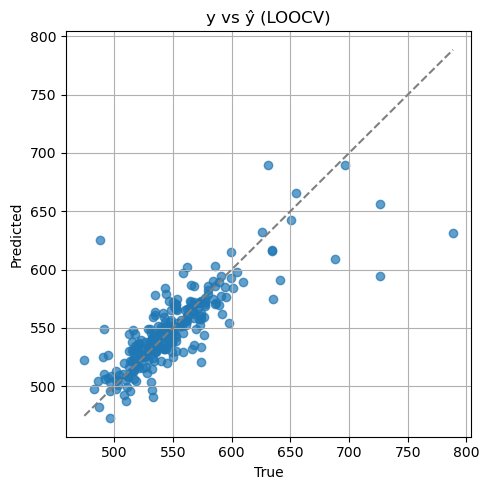

dwave1 LOOCV R²: 0.6493939485236377
LOOCV R²: 0.3787


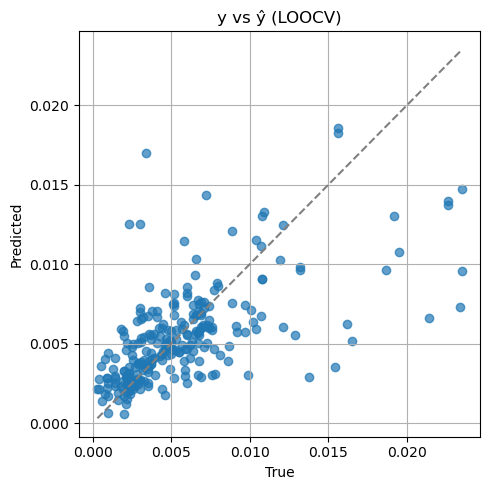

dstrength1 LOOCV R²: 0.3787488055193422


In [3]:
result_mwave1 = loocv_gpy(df_all, X_cols, Y_col_mwave1, standardize=True, use_ard=True)
print("mwave1 LOOCV R²:", result_mwave1)

result_mstrength1 = loocv_gpy(df_all, X_cols, Y_col_mstrength1, standardize=True, use_ard=True)
print("mstrength1 LOOCV R²:", result_mstrength1)

result_dwave1 = loocv_gpy(df_all, X_cols, Y_col_dwave1, standardize=True, use_ard=True)
print("dwave1 LOOCV R²:", result_dwave1)

result_dstrength1 = loocv_gpy(df_all, X_cols, Y_col_dstrength1, standardize=True, use_ard=True)
print("dstrength1 LOOCV R²:", result_dstrength1)

# 補1　ARDなし

LOOCV R²: 0.9934


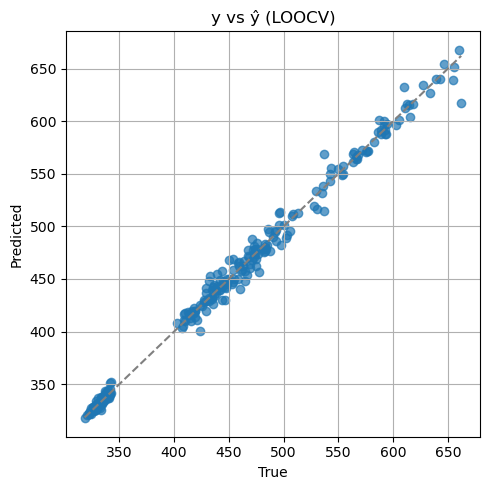

mwave1 LOOCV R² (NON ARD): 0.993433773032761
LOOCV R²: 0.9754


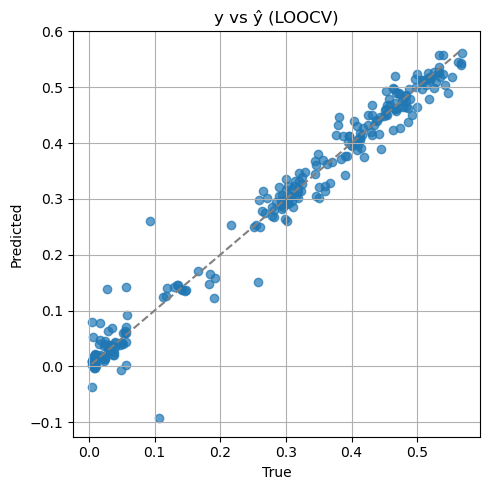

mstrength1 LOOCV R² (NON ARD): 0.9754455584943597
LOOCV R²: 0.6517


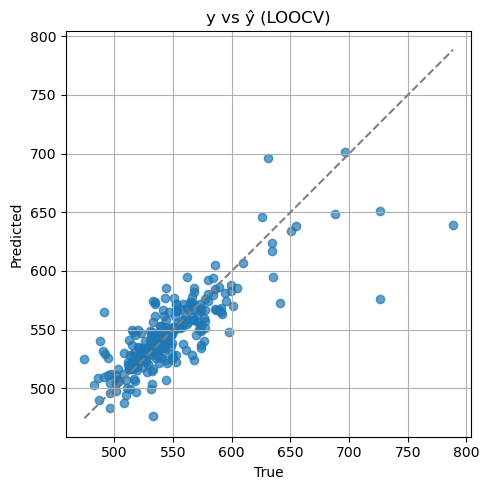

dwave1 LOOCV R² (NON ARD): 0.6517308911618933
LOOCV R²: 0.2860


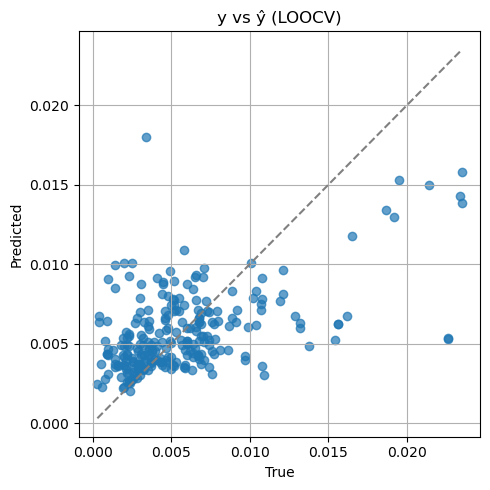

dstrength1 LOOCV R² (NON ARD): 0.2859509213155663


In [4]:
result_mwave1_NONARD = loocv_gpy(df_all, X_cols, Y_col_mwave1, standardize=True, use_ard=False)
print("mwave1 LOOCV R² (NON ARD):", result_mwave1_NONARD)

result_mstrength1_NONARD = loocv_gpy(df_all, X_cols, Y_col_mstrength1, standardize=True, use_ard=False)
print("mstrength1 LOOCV R² (NON ARD):", result_mstrength1_NONARD)

result_dwave1_NONARD = loocv_gpy(df_all, X_cols, Y_col_dwave1, standardize=True, use_ard=False)
print("dwave1 LOOCV R² (NON ARD):", result_dwave1_NONARD)

result_dstrength1_NONARD = loocv_gpy(df_all, X_cols, Y_col_dstrength1, standardize=True, use_ard=False)
print("dstrength1 LOOCV R² (NON ARD):", result_dstrength1_NONARD)

# 補2　標準化なし

In [14]:
result_mwave1_NONSTAN = loocv_gpy(df_all, X_cols, Y_col_mwave1, standardize=False, use_ard=True)
print("mwave1 LOOCV R² (NON STANDARD):", result_mwave1_NONSTAN)

result_mstrength1_NONSTAN = loocv_gpy(df_all, X_cols, Y_col_mstrength1, standardize=False, use_ard=True)
print("mstrength1 LOOCV R² (NON STANDARD):", result_mstrength1_NONSTAN)

result_dwave1_NONSTAN = loocv_gpy(df_all, X_cols, Y_col_dwave1, standardize=False, use_ard=True)
print("dwave1 LOOCV R² (NON STANDARD):", result_dwave1_NONSTAN)

result_dstrength1_NONSTAN = loocv_gpy(df_all, X_cols, Y_col_dstrength1, standardize=False, use_ard=True)
print("dstrength1 LOOCV R² (NON STANDARD):", result_dstrength1_NONSTAN)

 c:\Users\kaker\anaconda3\envs\BO_test\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 c:\Users\kaker\anaconda3\envs\BO_test\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 c:\Users\kaker\anaconda3\envs\BO_test\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in divide
 c:\Users\kaker\anaconda3\envs\BO_test\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in divide


LinAlgError: not positive definite, even with jitter.

# 5.カーネルExponential

 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166:

LOOCV R²: 0.9883


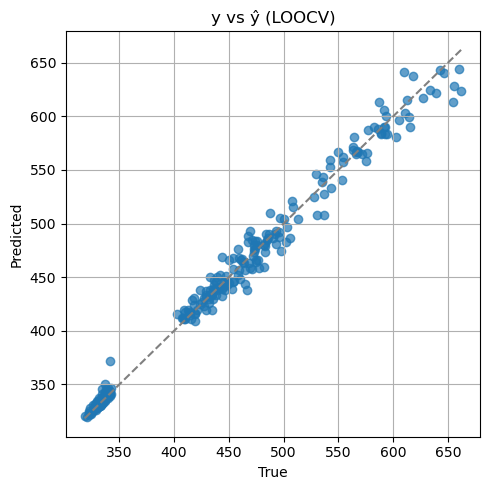

mwave1 LOOCV R² (Exponential Kernel): 0.98829522741641
LOOCV R²: 0.9686


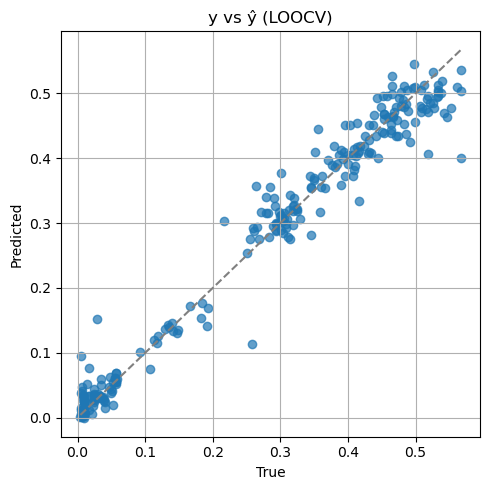

mstrength1 LOOCV R² (Exponential Kernel): 0.9685920802975428
LOOCV R²: 0.6891


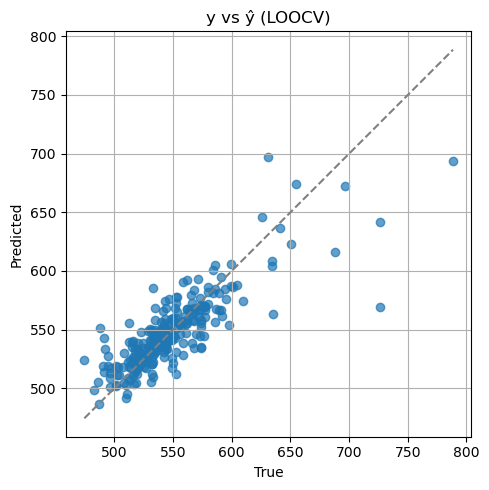

dwave1 LOOCV R² (Exponential Kernel): 0.6890956737462528
LOOCV R²: 0.4057


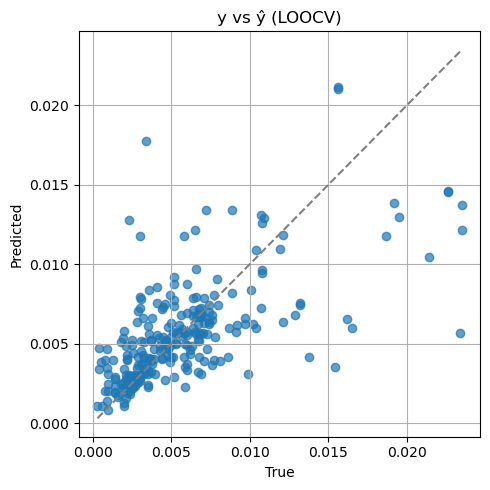

dstrength1 LOOCV R² (Exponential Kernel): 0.4057047068422611


In [5]:
kernel_exp = GPy.kern.Exponential(input_dim=len(X_cols), ARD=True)

result_mwave1_exp = loocv_gpy(df_all, X_cols, Y_col_mwave1, standardize=True, use_ard=True, kernel=kernel_exp)
print("mwave1 LOOCV R² (Exponential Kernel):", result_mwave1_exp)

result_mstrength1_exp = loocv_gpy(df_all, X_cols, Y_col_mstrength1, standardize=True, use_ard=True, kernel=kernel_exp)
print("mstrength1 LOOCV R² (Exponential Kernel):", result_mstrength1_exp)

result_dwave1_exp = loocv_gpy(df_all, X_cols, Y_col_dwave1, standardize=True, use_ard=True, kernel=kernel_exp)
print("dwave1 LOOCV R² (Exponential Kernel):", result_dwave1_exp)

result_dstrength1_exp = loocv_gpy(df_all, X_cols, Y_col_dstrength1, standardize=True, use_ard=True, kernel=kernel_exp)
print("dstrength1 LOOCV R² (Exponential Kernel):", result_dstrength1_exp)

In [6]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

def create_fp_dataframe(df, smiles_col="dimer_smi", radius=2, n_bits=2048):
    """
    DataFrame から指定した SMILES 列を読み込み、Morgan フィンガープリント
    をビットベクトル化して新しい DataFrame として返す。

    Args:
        df (pd.DataFrame): 元の DataFrame（インデックスはそのまま利用）
        smiles_col (str): SMILES が入っているカラム名
        radius (int): Morgan fingerprint の半径
        n_bits (int): フィンガープリント長

    Returns:
        pd.DataFrame: 行数は df と同じ、列は FP_0～FP_{n_bits-1}
    """
    # 1. SMILES リスト取得
    smiles_list = df[smiles_col].tolist()
    
    # 2. フィンガープリント生成
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            fps.append(np.zeros(n_bits, dtype=int))
            continue
        bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=int)
        DataStructs.ConvertToNumpyArray(bv, arr)
        fps.append(arr)
    
    # 3. ndarray 化＆DataFrame 化
    fps_array = np.vstack(fps)  # shape = (len(df), n_bits)
    col_names = [f"FP_{i}" for i in range(n_bits)]
    df_fp = pd.DataFrame(fps_array, columns=col_names, index=df.index)
    
    return df_fp

# 使い方例

df_fp = create_fp_dataframe(df_all, smiles_col="dimer_smi", radius=2, n_bits=2048)
print(df_fp.shape)
X_cols_FP = df_fp.columns.tolist()  # 新しいフィンガープリントカラム名リスト
df_fp.head()


(256, 2048)


,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [20]:
df_all_FP = pd.concat([df_all, df_fp], axis=1)
# df_FPの0しかないカラムを抜く
df_FP_NONE0 = df_fp.loc[:, (df_fp != 0).any(axis=0)]
X_cols_FP_NONE0 = df_FP_NONE0.columns.tolist()
print(f"FP columns with non-zero values: {len(X_cols_FP_NONE0)}")


# df_FPの1しかないカラムを抜く
# ユニーク値の種類数が「1より大きい」カラムだけを残す
df_FP_NONE1 = df_fp.loc[:, df_fp.nunique(dropna=False) > 1]

# カラム名リスト
X_cols_FP_NONE1 = df_FP_NONE1.columns.tolist()
print(f"FP columns with more than one unique value: {len(X_cols_FP_NONE1)}")



FP columns with non-zero values: 213
FP columns with more than one unique value: 189


 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py

LOOCV R²: 0.3011


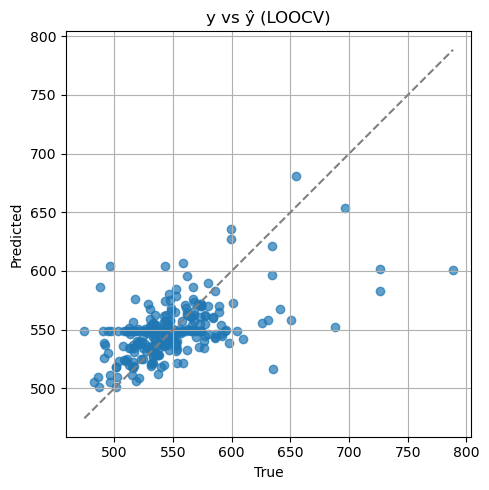

dwave1 LOOCV R² (Exponential Kernel): 0.30106801785413206


 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/macmini/opt/anaconda3/envs/BO_test/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137:

LOOCV R²: 0.1358


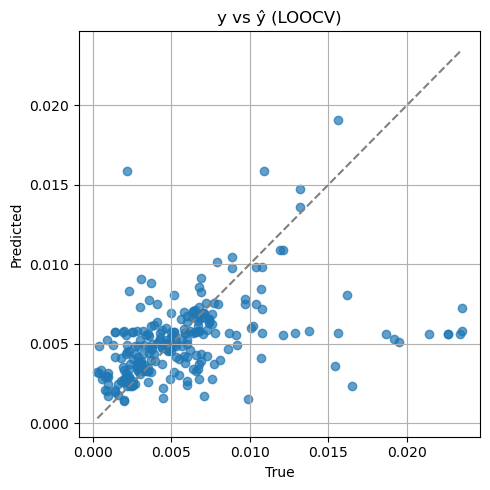

dstrength1 LOOCV R² (Exponential Kernel): 0.1357946881138833


In [8]:
kernel_exp = GPy.kern.Exponential(input_dim=len(X_cols_FP_NONE0), ARD=True)

result_FP_dwave1_exp = loocv_gpy(df_all_FP, X_cols_FP_NONE0, Y_col_dwave1, standardize=True, use_ard=True, kernel=kernel_exp)
print("dwave1 LOOCV R² (Exponential Kernel):", result_FP_dwave1_exp)

result_FP_dstrength1_exp = loocv_gpy(df_all_FP, X_cols_FP_NONE0, Y_col_dstrength1, standardize=True, use_ard=True, kernel=kernel_exp)
print("dstrength1 LOOCV R² (Exponential Kernel):", result_FP_dstrength1_exp)



LOOCV R²: 0.4193


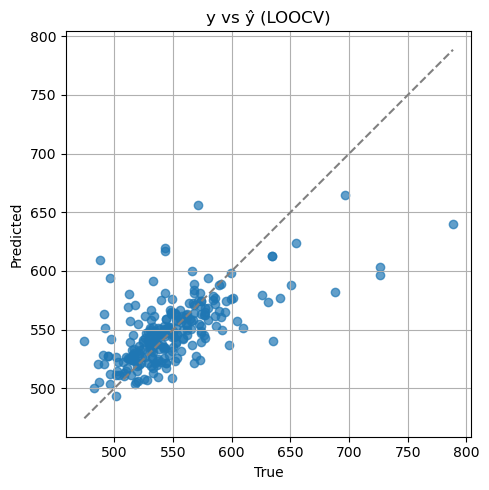

dwave1 LOOCV R² (Exponential Kernel): 0.4193498269733633
LOOCV R²: 0.3179


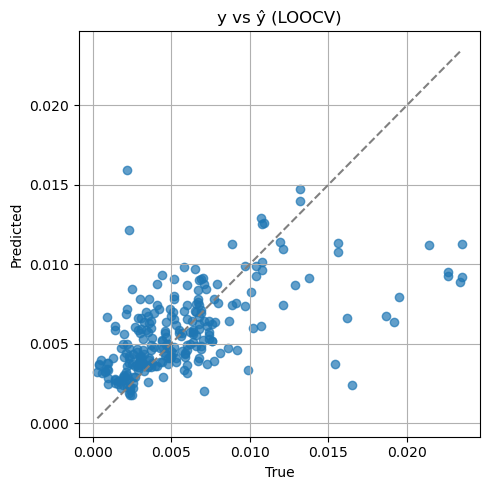

dstrength1 LOOCV R² (Exponential Kernel): 0.3178716923873526


In [ ]:
kernel_exp = GPy.kern.Exponential(input_dim=len(X_cols_FP_NONE0), ARD=False)

result_FP_dwave1_exp = loocv_gpy(df_all_FP, X_cols_FP_NONE0, Y_col_dwave1, standardize=True, use_ard=False, kernel=kernel_exp)
print("dwave1 LOOCV R² (Exponential Kernel):", result_FP_dwave1_exp)

result_FP_dstrength1_exp = loocv_gpy(df_all_FP, X_cols_FP_NONE0, Y_col_dstrength1, standardize=True, use_ard=False, kernel=kernel_exp)
print("dstrength1 LOOCV R² (Exponential Kernel):", result_FP_dstrength1_exp)


LOOCV R²: 0.4193


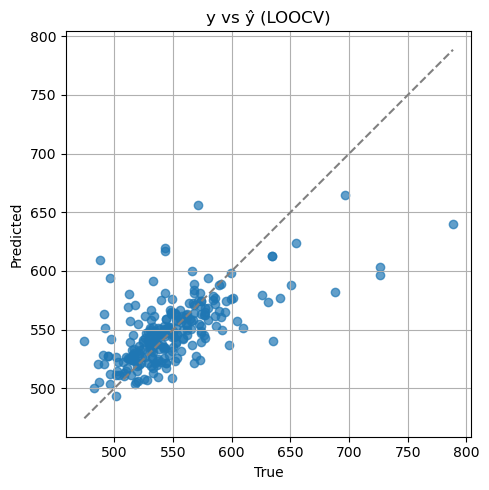

dwave1 LOOCV R² (Exponential Kernel): 0.4193498269620738
LOOCV R²: 0.9419


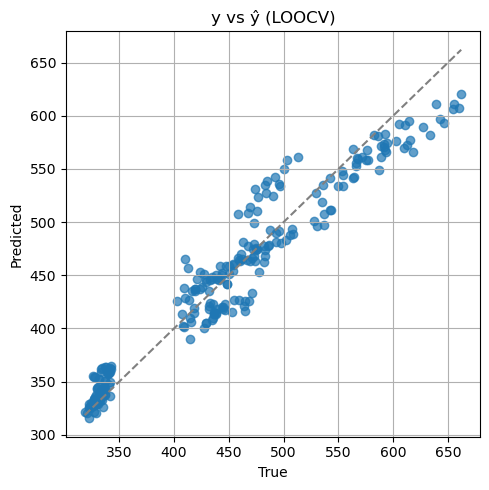

In [23]:
kernel_exp = GPy.kern.Exponential(input_dim=len(X_cols_FP_NONE1), ARD=False)

result_FP_dwave1_exp = loocv_gpy(df_all_FP, X_cols_FP_NONE1, Y_col_dwave1, standardize=True, use_ard=False, kernel=kernel_exp)
print("dwave1 LOOCV R² (Exponential Kernel):", result_FP_dwave1_exp)


result_FP_dstrength1_exp = loocv_gpy(df_all_FP, X_cols_FP_NONE1, Y_col_mwave1, standardize=True, use_ard=False, kernel=kernel_exp)

LOOCV R²: 0.4193


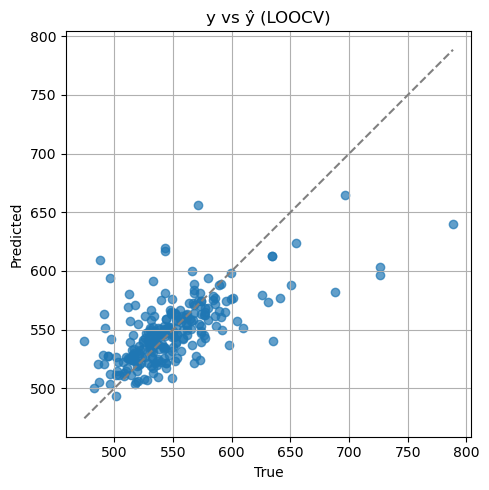

dwave1 LOOCV R² (Exponential Kernel): 0.4193498269733633
LOOCV R²: 0.3179


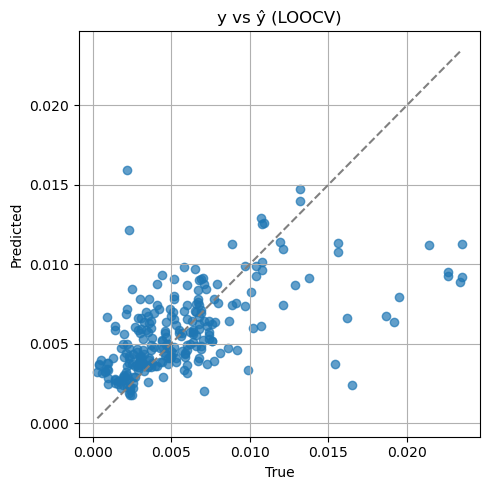

dstrength1 LOOCV R² (Exponential Kernel): 0.3178716923873526


In [15]:
kernel_exp = GPy.kern.Exponential(input_dim=len(X_cols_FP_NONE0), ARD=False)

result_FP_dwave1_exp = loocv_gpy(df_all_FP, X_cols_FP_NONE0, Y_col_dwave1, standardize=True, use_ard=False, kernel=kernel_exp)
print("dwave1 LOOCV R² (Exponential Kernel):", result_FP_dwave1_exp)

result_FP_dstrength1_exp = loocv_gpy(df_all_FP, X_cols_FP_NONE0, Y_col_dstrength1, standardize=True, use_ard=False, kernel=kernel_exp)
print("dstrength1 LOOCV R² (Exponential Kernel):", result_FP_dstrength1_exp)